Parker Nelms
</br>CS 458
</br>12/13/22

## Take in data and preprocess:

<AxesSubplot:>

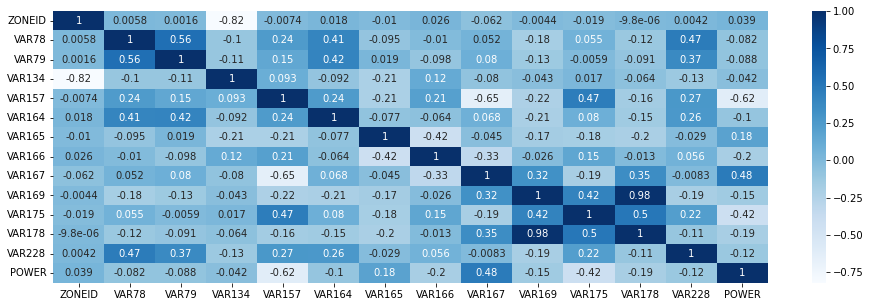

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor

#read in the train and test data from the csv files 
solar_data = pd.read_csv('solar_training.csv')
solar_test = pd.read_csv('solar_test.csv')

#drop missing values from the dataset 
solar_test = solar_test.dropna()

#plot the correlation matrix
plt.figure(figsize = (16,5))
corr = solar_data.corr()
sns.heatmap(corr, cmap="Blues", annot=True)

We see high correlation between VAR178 & VAR169. VAR78, 79, and 134 have low correlations with the power output. We can drop these to reduce training time and still maintain a decent MAE and RMSE.

In [2]:
#drop unneeded data from the df
solar_data = solar_data.drop("VAR78", axis='columns')
solar_data = solar_data.drop("VAR79", axis='columns')
solar_data = solar_data.drop("VAR134", axis='columns')
solar_data = solar_data.drop("VAR169", axis='columns')
solar_test = solar_test.drop("VAR78", axis='columns')
solar_test = solar_test.drop("VAR79", axis='columns')
solar_test = solar_test.drop("VAR134", axis='columns')
solar_test = solar_test.drop("VAR169", axis='columns')

In [3]:
from sklearn.decomposition import PCA
#separate the time stamp to be more usable

#hours of historical data to consider
HOURS_CONSIDERED = 24

def separate_sites(dataset):
    '''
    Separate the data into the three zones and convert timestamps to a computer readable number.
    Returns the site arrays
    '''
    site_array1 = []
    site_array2 = []
    site_array3 = []
    
    for x in dataset.to_numpy():
        time = x[1][4:6] + x[1][6:8] + x[1][9:11]
        x[1] = int(time)

        if x[0] == 1:
            site_array1.append(x)
        elif x[0] == 2:
            site_array2.append(x)
        elif x[0] == 3:
            site_array3.append(x)
            
    return site_array1,site_array2,site_array3

def convert_to_trainable(site_array, hours_considered):
    '''
    Convert the data to time series data.
    Returns the time series data and the Pt+24 target values as an array
    '''
    y_array = []
    pp_array = []
    for i in range(len(site_array[:-(24+hours_considered)])):
        sample = []
        for j in range(hours_considered):
            for m in site_array[i+j][1:]:
                sample.append(m)

        y_array.append(site_array[i+hours_considered+23][-1])
        pp_array.append(sample)

    return pp_array, y_array

#separate site data for train and test data sets
train_array1,train_array2,train_array3 = separate_sites(solar_data)
test_array1,test_array2,test_array3 = separate_sites(solar_test)

#convert to time series for train and test
post_train_array1, y1_train = convert_to_trainable(train_array1, HOURS_CONSIDERED)
post_train_array2, y2_train = convert_to_trainable(train_array2, HOURS_CONSIDERED)
post_train_array3, y3_train = convert_to_trainable(train_array3, HOURS_CONSIDERED)
post_test_array1, y1_test = convert_to_trainable(test_array1, HOURS_CONSIDERED)
post_test_array2, y2_test = convert_to_trainable(test_array2, HOURS_CONSIDERED)
post_test_array3, y3_test = convert_to_trainable(test_array3, HOURS_CONSIDERED)


def normalize(data_array): 
    '''
    Normalizes feature data in a dataframe from 0 to 1.
    Returns normalized dataframe
    '''
    df = pd.DataFrame(data_array)
    df =(df-df.min())/(df.max()-df.min())
    data_array = df.to_numpy()
    
    return data_array 

#normalize the time series data
post_train_array1 = normalize(post_train_array1)
post_test_array1 = normalize(post_test_array1)
post_train_array2 = normalize(post_train_array2)
post_test_array2 = normalize(post_test_array2)
post_train_array3 = normalize(post_train_array3)
post_test_array3 = normalize(post_test_array3)

## Train the model:

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [5]:
#optimizing the hyperparameters using gridsearch
'''#parameter grid for optimizing hyperparameters 
param_grid = {"n_estimators": [100, 110],
              "max_depth": [None, 5, 10, 20],
              "min_samples_split": [2,4,6],
              "min_samples_leaf": [1,2,3,4]}

estimator = RandomForestRegressor()
reg = GridSearchCV(estimator=estimator, param_grid=param_grid,n_jobs=-1)
reg.fit(post_train_array1, y1_train)'''

#train the models for each of the three sites
reg1 = RandomForestRegressor(max_depth=20, min_samples_leaf=2, n_estimators=100, max_features = 'sqrt')
reg1.fit(post_train_array1, y1_train)

reg2 = RandomForestRegressor(max_depth=20, min_samples_leaf=2, n_estimators=100, max_features = 'sqrt')
reg2.fit(post_train_array2, y2_train)

reg3 = RandomForestRegressor(max_depth=20, min_samples_leaf=2, n_estimators=100, max_features = 'sqrt')
reg3.fit(post_train_array3, y3_train)

RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2)

## Unused models (commented out so they don't run):

In [6]:
'''
#train with MLP regressor for all three sites
from sklearn.neural_network import MLPRegressor

reg1 = MLPRegressor(hidden_layer_sizes = 14, max_iter = 1000, activation = 'relu', learning_rate_init = 0.001)
reg1.fit(post_train_array1, y1_train)

reg2 = MLPRegressor(hidden_layer_sizes = 14, max_iter = 1000, activation = 'relu', learning_rate_init = 0.001)
reg2.fit(post_train_array2, y2_train)

reg3 = MLPRegressor(hidden_layer_sizes = 14, max_iter = 1000, activation = 'relu', learning_rate_init = 0.001)
reg3.fit(post_train_array3, y3_train)'''

"\n#train with MLP regressor for all three sites\nfrom sklearn.neural_network import MLPRegressor\n\nreg1 = MLPRegressor(hidden_layer_sizes = 14, max_iter = 1000, activation = 'relu', learning_rate_init = 0.001)\nreg1.fit(post_train_array1, y1_train)\n\nreg2 = MLPRegressor(hidden_layer_sizes = 14, max_iter = 1000, activation = 'relu', learning_rate_init = 0.001)\nreg2.fit(post_train_array2, y2_train)\n\nreg3 = MLPRegressor(hidden_layer_sizes = 14, max_iter = 1000, activation = 'relu', learning_rate_init = 0.001)\nreg3.fit(post_train_array3, y3_train)"

In [7]:
'''
#train with SVR regressor for all three sites
from sklearn.svm import SVR

reg = SVR()
reg.fit(post_train_array1, y1_train)'''

'\n#train with SVR regressor for all three sites\nfrom sklearn.svm import SVR\n\nreg = SVR()\nreg.fit(post_train_array1, y1_train)'

In [8]:
'''#train with stacking regressor for all three sites
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import GradientBoostingRegressor

estimators = [('mlp', MLPRegressor()),
              ('svr', SVR())]

reg = StackingRegressor(estimators=estimators,
                        final_estimator=GradientBoostingRegressor())

reg.fit(post_train_array1, y1_train)'''

"#train with stacking regressor for all three sites\nfrom sklearn.ensemble import StackingRegressor\nfrom sklearn.linear_model import RidgeCV\nfrom sklearn.ensemble import GradientBoostingRegressor\n\nestimators = [('mlp', MLPRegressor()),\n              ('svr', SVR())]\n\nreg = StackingRegressor(estimators=estimators,\n                        final_estimator=GradientBoostingRegressor())\n\nreg.fit(post_train_array1, y1_train)"

## Generate predictions and plot them:

MAE plant 1:  0.054812759233879176
RMSE plant 1:  0.11062242607891144
MAE plant 2:  0.06225988941173148
RMSE plant 2:  0.11954724977400044
MAE plant 3:  0.062292944179062726
RMSE plant 3:  0.11956521054296475


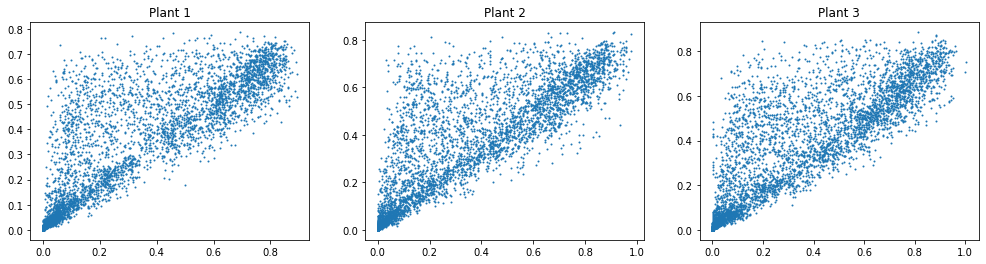

In [14]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt 

#get predictions for each model and calculate error scores
pred1 = reg1.predict(post_test_array1)
pred2 = reg2.predict(post_test_array2)
pred3 = reg3.predict(post_test_array3)
print("MAE plant 1: ",mean_absolute_error(y1_test, pred1))
print("RMSE plant 1: ",mean_squared_error(y1_test, pred1, squared = False ))
print("MAE plant 2: ",mean_absolute_error(y2_test, pred2))
print("RMSE plant 2: ",mean_squared_error(y2_test, pred2, squared = False ))
print("MAE plant 3: ",mean_absolute_error(y3_test, pred3))
print("RMSE plant 3: ",mean_squared_error(y3_test, pred3, squared = False ))

#plot the predicted values against the true values
fig, axs = plt.subplots(1, 3)
fig.set_figwidth(17)
axs[0].set_title("Plant 1")
axs[1].set_title("Plant 2")
axs[2].set_title("Plant 3")
axs[0].scatter(y1_test, pred1, s=1)
axs[1].scatter(y2_test, pred2, s=1)
axs[2].scatter(y3_test, pred3, s=1)
plt.show()

In [10]:
#plots the comparison line for a given zone
def plot_comparison_line(y,pred,start_time,window_size,plant):  
    season = ['summer','fall','winter','spring']
    time = []
    temp = solar_test.to_numpy()
    
    #create a time list to use as x-tick labels
    for x in range(2*HOURS_CONSIDERED, len(y1_test) + 2*HOURS_CONSIDERED):
        time.append(temp[x-1][1])
        
    #create and plot subplots (4 seasonal plots)
    fig, axs = plt.subplots(1, 4)
    fig.set_figwidth(17)
        
    for x in range(0,4):
        
        #define 24 hour plot window
        end_time = start_time + window_size

        axs[x].axis([start_time, end_time, 0, 1])
        axs[x].plot(time, y,'-ro', markersize = 3, label = "Truth", alpha=0.5)
        axs[x].plot(time, pred,'-bo', markersize = 3, label = "Predicted")
        axs[x].legend(fontsize = 'large')
        axs[x].set_xticks(range(start_time,end_time,4), labels = time[start_time:end_time:4],rotation=45, ha="right",fontsize = 'small')    
        axs[x].set_title("Plant {} {}".format(plant, season[x]))
        axs[x].set_ylabel("Power")
        axs[x].set_xlabel("Time")
        
        start_time += 2184
    
    return time
   


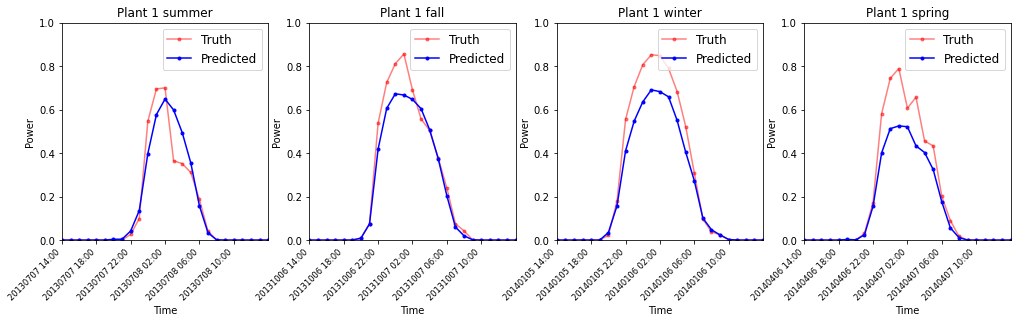

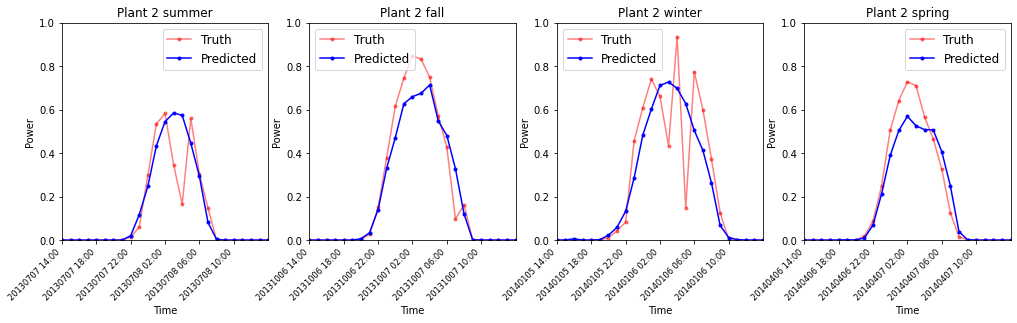

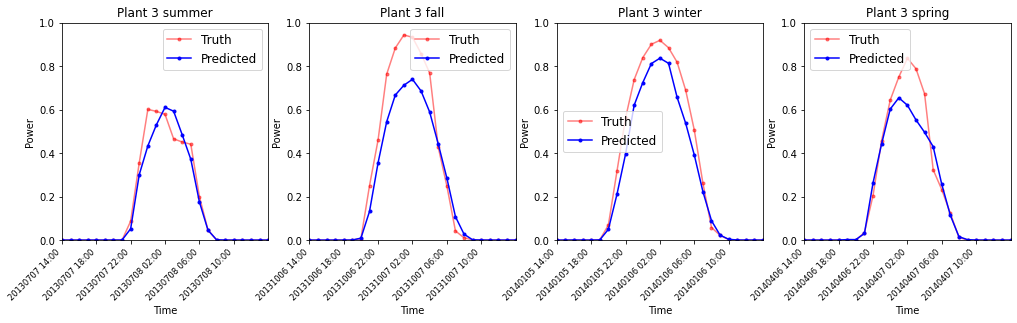

In [11]:
time = plot_comparison_line(y1_test,pred1,110,24,1)
time = plot_comparison_line(y2_test,pred2,110,24,2)
time = plot_comparison_line(y3_test,pred3,110,24,3)

## Verification script (runs after plotting day comparisons):

In [12]:
''' 
Replace i value with the index of the timestamp you want to check.
0 will give the timestamp of the first available predictable time along with its true value and predicted value
    
Additionally, replace the numbers "X" in yX_test and predX to whichever zone you want to verify.
'''
i = 122

print("Timestamp: ", time[i])
print("True value: ", y1_test[i])
print("Predicted value: ", pred1[i])

Timestamp:  20130708 02:00
True value:  0.700064103
Predicted value:  0.6484486971408114
